In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import time

## Read data

In [2]:
from src.features import *
train = load_raw()
cols = imply_columns(train)

In [3]:
assert not train['Unnamed: 0'].duplicated().any()

In [4]:
train = train.set_index('Unnamed: 0')

In [5]:
train.shape, train.columns

((195402, 39),
 Index(['1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
        '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
        '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
        '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
        '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
        '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
        '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
        '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
        '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
        'Country Name', 'Series Code', 'Series Name'],
       dtype='object'))

In [6]:
# pd.isnull(train[cols['features']]).sum(axis=1).sort_values(ascending=True).head(n=20)
train.shape[0], len(np.where(pd.isnull(train[cols['features']]).sum(axis=1) < 5)[0])
# train.iloc[0,'1972 [YR1972]']
# pd.isnull(train.loc[0,'1972 [YR1972]'])
# train.head()
# train.loc[131876]

(195402, 61280)

## read submission file

In [7]:
df_submit = pd.read_csv('data/raw/submission.csv').set_index('Unnamed: 0')
df_submit.head()

,2008 [YR2008],2012 [YR2012]
Unnamed: 0,,
559,NaN,NaN
618,NaN,NaN
753,NaN,NaN
1030,NaN,NaN
1896,NaN,NaN


In [8]:
len(set(train.loc[df_submit.index]['Country Name']))

206

In [9]:
set(train.loc[df_submit.index]['Series Code'])

{'2.1', '4.1', '5.1', '6.1', '6.7', '7.8', '8.16'}

In [10]:
submit_inds = list(set(df_submit.index))
submit_inds.sort()
submit_inds[:10]

[559, 618, 753, 1030, 1896, 1955, 2090, 2690, 3233, 3292]

## preprocess data to backfill nan

In [11]:
my_rename = {x: x[6:-1] for x in cols['features']}
train.rename(columns=my_rename, inplace=True)

In [12]:
cols['features'] = list(my_rename.values())
cols['features'].sort()
cols['features'][:5]

['YR1972', 'YR1973', 'YR1974', 'YR1975', 'YR1976']

In [13]:
# wide to long format so that years are an index along the rows
train = pd.wide_to_long(train.reset_index(), ["YR"], i="Unnamed: 0", j="year").reset_index(level='year')

In [14]:
# rename YR to "value"
train.rename(columns={'YR': 'value'}, inplace=True)

In [15]:
train['year'] = train['year'].apply(lambda x: int(x))
train['year'].head().values

array([1972, 1972, 1972, 1972, 1972])

In [16]:
# plot again just to confirm that wide-to-long worked
country = 'Kenya' # 'Poland'
series = 'Net taxes on products (current LCU)'
subtrain = train[(train['Country Name']==country) & (train['Series Name']==series)]
subtrain = subtrain.set_index('year')
subtrain.head()

,Country Name,Series Name,Series Code,value
year,,,,
1972,Kenya,Net taxes on products (current LCU),NY.TAX.NIND.CN,1.276000e+09
1973,Kenya,Net taxes on products (current LCU),NY.TAX.NIND.CN,1.776000e+09
1974,Kenya,Net taxes on products (current LCU),NY.TAX.NIND.CN,2.438000e+09
1975,Kenya,Net taxes on products (current LCU),NY.TAX.NIND.CN,2.790000e+09
1976,Kenya,Net taxes on products (current LCU),NY.TAX.NIND.CN,3.510000e+09


In [17]:
subtrain['value'].head()

year
1972    1.276000e+09
1973    1.776000e+09
1974    2.438000e+09
1975    2.790000e+09
1976    3.510000e+09
Name: value, dtype: float64

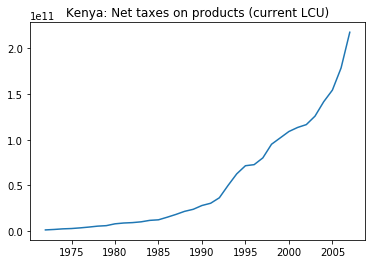

In [18]:
plt.plot(subtrain['value'])
plt.title("%s: %s"%(country, series))
plt.show()

## group and backfill

In [19]:
train.shape

(7034472, 5)

In [20]:
# test
df = pd.DataFrame([[np.nan, 2, np.nan, 0, 2, 2],
                   [3, 4, np.nan, 1, 1, 2],
                   [np.nan, np.nan, np.nan, 5, 1, 3],
                   [np.nan, 3, np.nan, 4, 1, 4],
                  ],
                  columns=list('ABCDEF'))
df['B'] = df.sort_values('F', ascending=True).groupby(['E'])['B'].fillna(method='ffill')
df

,A,B,C,D,E,F
0,NaN,2.0,NaN,0,2,2
1,3.0,4.0,NaN,1,1,2
2,NaN,4.0,NaN,5,1,3
3,NaN,3.0,NaN,4,1,4


In [21]:
train.shape

(7034472, 5)

In [22]:
n_nan_before = pd.isnull(train['value']).sum()
print('before: number of nan: %s'%n_nan_before)

before: number of nan: 3320285


In [23]:
# around 15 seconds
print(time.ctime(), 'start group')
train2 = train.copy()
train2 = train2.sort_values(['Country Name', 'Series Code', 'year'], ascending=True)
t_group = train2.groupby(['Country Name', 'Series Code'])
print(time.ctime(), 'end group')

Mon May 21 14:19:01 2018 start group
Mon May 21 14:19:06 2018 end group


In [24]:
# around 1 minute
print(time.ctime(), 'start fill')
train2['value'] = t_group['value'].fillna(method='ffill')
print(time.ctime(), 'end fill')

Mon May 21 14:19:06 2018 start fill
Mon May 21 14:19:52 2018 end fill


In [25]:
n_nan_after = pd.isnull(train2['value']).sum()
print('after: number of nan: %s'%n_nan_after)

after: number of nan: 2789631


## Fill remaining nan with bfill

In [26]:
# group again and backfill this time ... this is kind of cheating
# ~ 1 minute
print(time.ctime(), 'start fill')
t_group = train2.groupby(['Country Name', 'Series Code'])
train2['value'] = t_group['value'].fillna(method='bfill')
print(time.ctime(), 'end fill')
n_nan_after2 = pd.isnull(train2['value']).sum()
print('after: number of nan: %s'%n_nan_after2)

Mon May 21 14:19:52 2018 start fill
Mon May 21 14:20:38 2018 end fill
after: number of nan: 0


In [27]:
train2.reset_index().head()

,Unnamed: 0,year,Country Name,Series Name,Series Code,value
0,16,1972,Afghanistan,Achieve universal primary education,2.1,0.267007
1,16,1973,Afghanistan,Achieve universal primary education,2.1,0.267007
2,16,1974,Afghanistan,Achieve universal primary education,2.1,0.267007
3,16,1975,Afghanistan,Achieve universal primary education,2.1,0.267007
4,16,1976,Afghanistan,Achieve universal primary education,2.1,0.267007


## pivot table

- temporal dimension: year
- spatial dimension: country/series pair

This results in a transpose of the original dataframe

In [94]:
train3 = train2.reset_index().pivot(index='year', columns='Unnamed: 0', values='value')
train3.head()

Unnamed: 0,0,1,2,4,5,6,8,9,10,11,...,286107,286108,286109,286110,286112,286113,286114,286115,286116,286117
year,,,,,,,,,,,,,,,,,,,,,
1972,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5
1973,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5
1974,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5
1975,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5
1976,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5


In [29]:
train3[[16,559]].tail()

Unnamed: 0,16,559
year,,
2003,0.279609,0.325
2004,0.279609,0.360
2005,0.279609,0.395
2006,0.279609,0.430
2007,0.279609,0.465


In [30]:
train3.shape

(36, 195402)

In [42]:
pd.isnull(train3[submit_inds]).sum(axis=0).max()

0

## use RF feature importances from 0.5/0.6

## multi-variate AR

In [132]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.decomposition import PCA

# Method 1: target is a single country/series pair, features are all else
# diabetes_X = diabetes_0[list(set(diabetes_0.columns) - set([index]))].values
# diabetes_y = train3[index].values

# Method 2: features are lagged data (drop 1st row since cannot predict)
diabetes_X = []
n_shift = 3
for i in range(n_shift):
    diabetes_X.append(train3[submit_inds].shift(i+1))

diabetes_X.append(train3.reset_index()[['year']])
diabetes_X = np.concatenate(diabetes_X, axis=1)
diabetes_y = train3[submit_inds]

# to avoid multi-colinearity, reduce features

# Method 1: select top n features
# http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html#sphx-glr-auto-examples-plot-compare-reduction-py
# This beats the performance of the PCA
# mdl = SelectKBest(f_regression, k=40) # 20 and 40 are good
# diabetes_X = mdl.fit_transform(diabetes_X, diabetes_y)

# Method 2: PCA to reduce features
# # mdl = PCA(n_components='mle') # TODO report bug
# # mdl = PCA(n_components='mle', svd_solver = 'full') # mle not supported for n_samples < n_features
# mdl = PCA(n_components=20, svd_solver = 'full') # 20 is too small resulting in too large error
# diabetes_X = mdl.fit_transform(diabetes_X)


diabetes_X = diabetes_X[n_shift:]
diabetes_y = diabetes_y[n_shift:]

diabetes_X.shape, diabetes_y.shape

((33, 2212), (33, 737))

In [133]:
# Split the data into training/testing sets
n_test = 0 # FIXME: 0 2

In [134]:
if n_test > 0:
    diabetes_X_train = diabetes_X[:-1*n_test]
    diabetes_X_test = diabetes_X[-1*n_test:]
else:
    diabetes_X_train = diabetes_X

# Split the targets into training/testing sets
if n_test > 0:
    diabetes_y_train = diabetes_y[:-1*n_test]
    diabetes_y_test = diabetes_y[-1*n_test:]
else:
    diabetes_y_train = diabetes_y

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
print('fit', diabetes_X_train.shape, diabetes_y_train.shape)
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
if n_test > 0:
    diabetes_y_pred = regr.predict(diabetes_X_test)

    pred_r2 = r2_score(diabetes_y_test, diabetes_y_pred)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f"
          % mean_squared_error(diabetes_y_test, diabetes_y_pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.2f' % pred_r2)
    
    #if pred_r2 > 1 or pred_r2 < -1.1:
    #    raise ValueError("prediction r2 on %s = %.2f > 1 or < 0. Aborting"%(index, pred_r2))

fit (33, 2212) (33, 737)


## predict

In [135]:
def year2col(x):
    return "%.0f [YR%.0f]"%(x, x)

year2col(2008), year2col(2012)

('2008 [YR2008]', '2012 [YR2012]')

In [138]:
df_submit2 = df_submit.copy()

df_submit2[year2col(2005)] = train3.loc[2005, df_submit2.index].transpose()
df_submit2[year2col(2006)] = train3.loc[2006, df_submit2.index].transpose()
df_submit2[year2col(2007)] = train3.loc[2007, df_submit2.index].transpose()

# df_submit2[year2col(2008)] = np.nan
df_submit2[year2col(2009)] = np.nan
df_submit2[year2col(2010)] = np.nan
df_submit2[year2col(2011)] = np.nan
# df_submit2[year2col(2012)] = np.nan

df_submit2.head()

,2008 [YR2008],2012 [YR2012],2005 [YR2005],2006 [YR2006],2007 [YR2007],2009 [YR2009],2010 [YR2010],2011 [YR2011]
Unnamed: 0,,,,,,,,
559,NaN,NaN,0.395000,0.430000,0.4650,NaN,NaN,NaN
618,NaN,NaN,0.012241,0.021071,0.0190,NaN,NaN,NaN
753,NaN,NaN,0.117700,0.114500,0.1115,NaN,NaN,NaN
1030,NaN,NaN,0.001000,0.001000,0.0010,NaN,NaN,NaN
1896,NaN,NaN,0.962000,0.962000,0.9610,NaN,NaN,NaN


Unnamed: 0  year
35          2008
Unnamed: 0  year
35          2009
Unnamed: 0  year
35          2010
Unnamed: 0  year
35          2011
Unnamed: 0  year
35          2012


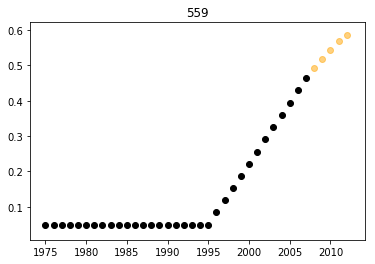

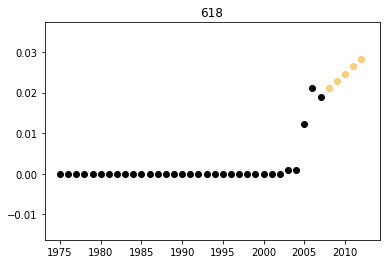

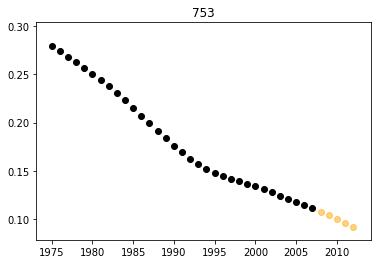

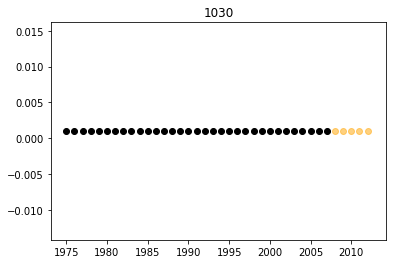

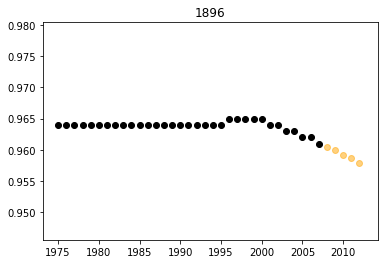

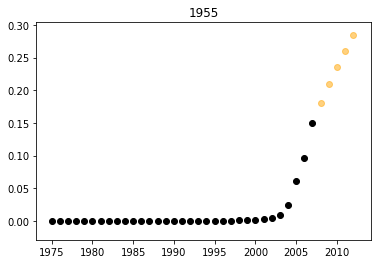

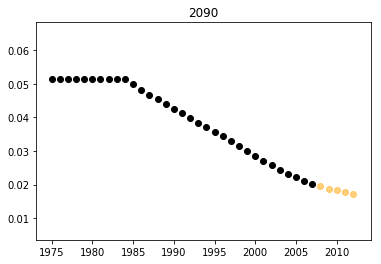

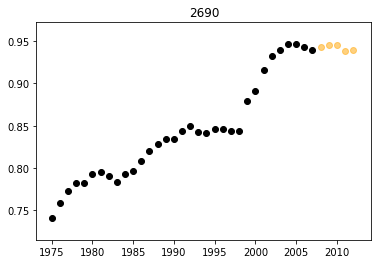

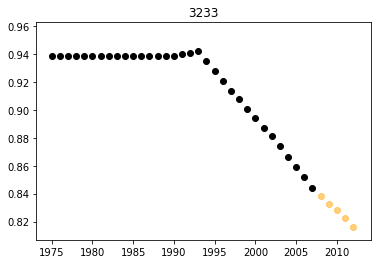

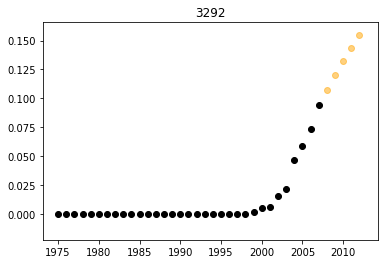

In [139]:
for i_pred2 in range(5):
    diabetes_y_pred23 = train3.reset_index()[['year']][-1:]+1+i_pred2
    print(diabetes_y_pred23)

    # FIXME original had year2-1+i_pred2 ... now doing year2+1+i_pred2
    # diabetes_y_pred2 = np.concatenate([diabetes_y_pred2, year2-1+i_pred2], axis=1)
    ## diabetes_y_pred20 = np.concatenate([diabetes_y_pred21, diabetes_y_pred22, diabetes_y_pred23], axis=1)
    diabetes_y_pred20 = [df_submit2[year2col(2008+i_pred2-j-1)].transpose().values.reshape((1,-1)) for j in range(n_shift)]
    diabetes_y_pred20 += [diabetes_y_pred23]
    diabetes_y_pred20 = np.concatenate(diabetes_y_pred20, axis=1)
    diabetes_y_pred21 = regr.predict(diabetes_y_pred20)
    df_submit2.loc[:,year2col(diabetes_y_pred23.values[0])] = diabetes_y_pred21.transpose()


for index in submit_inds[:10]: #[559, 618]:
    # print(train3.index[1:][:-1*n_test].shape, diabetes_y_train.shape, diabetes_y_train[:,submit_inds.index(index)].squeeze().shape)
    
    # Plot outputs
    plt.scatter(train3.index[n_shift:], diabetes_y[index].squeeze(), color='black')
        
    # print(year2)
    for i_pred2 in range(5):
        plt.scatter(2007+1+i_pred2, df_submit2.loc[index, year2col(2007+1+i_pred2)].squeeze(), color='orange', alpha=0.5)

    plt.title(index)
    plt.show()

In [140]:
df_submit2.head()

,2008 [YR2008],2012 [YR2012],2005 [YR2005],2006 [YR2006],2007 [YR2007],2009 [YR2009],2010 [YR2010],2011 [YR2011]
Unnamed: 0,,,,,,,,
559,0.491784,0.585715,0.395000,0.430000,0.4650,0.518896,0.544683,0.569177
618,0.021078,0.028353,0.012241,0.021071,0.0190,0.022892,0.024657,0.026461
753,0.107793,0.091867,0.117700,0.114500,0.1115,0.103898,0.100086,0.096137
1030,0.001000,0.001008,0.001000,0.001000,0.0010,0.001001,0.001003,0.001006
1896,0.960465,0.957823,0.962000,0.962000,0.9610,0.959936,0.959229,0.958663


## prepare submission file

In [141]:
df_submit3 = df_submit2[['2008 [YR2008]', '2012 [YR2012]']].copy()
df_submit3 = df_submit3.fillna(value=0)
df_submit3 = df_submit3.reset_index()[['Unnamed: 0', '2008 [YR2008]', '2012 [YR2012]']]
df_submit3.rename(columns={'Unnamed: 0': ''}, inplace=True)
fn1, fn2 = make_submission(df_submit3)
fn1, fn2

('../data/interim/submission_20180521_151500.csv',
 '../data/interim/submission_20180521_151500.csv.zip')